In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
import seaborn as sns
from sklearn import datasets
from tqdm import tqdm

%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.autograd import grad

SEED = 9999
torch.manual_seed(SEED)

In [4]:
plt.rcParams.update({'font.size': 20})

In [5]:
path = './input/'
os.listdir(path)

[]

In [6]:
Id = 2
N = 10000
SEED = 100


In [7]:
X, Y = datasets.make_moons(n_samples = 2*N)
Q = X[Y==0]
P = X[Y==1]

Q.shape, P.shape

((10000, 2), (10000, 2))

In [8]:
mu_q = Q[:,:2].mean(axis=0)
mu_p = P[:,:2].mean(axis=0)

mu_q, mu_p

(array([-2.63788991e-17,  6.36556105e-01]), array([ 1.        , -0.13655611]))

In [9]:
Q.shape, P.shape

((10000, 2), (10000, 2))

In [10]:
x = torch.FloatTensor(P[:3]).cuda()
y = torch.FloatTensor(Q[:3]).cuda()
x.shape, y.shape

(torch.Size([3, 2]), torch.Size([3, 2]))

In [11]:
class Ki(nn.Module):
    def __init__(self, features = 128):
        super(Ki, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=Id, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=Id)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op
        

In [12]:
ki = Ki().cuda()
summary(ki,(1,Id))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             384
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                 [-1, 1, 2]             258
Total params: 33,666
Trainable params: 33,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [13]:
class Psi(nn.Module):
    def __init__(self, features = 128):
        super(Psi, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=Id, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=1)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op
        

In [14]:
psi = Psi().cuda()
summary(psi,(1,Id))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             384
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                 [-1, 1, 1]             129
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [15]:
def PushForward(ki,x):
    gradPhi = ki(x)
    return gradPhi

In [16]:
def GradientPenalty(psi, ki, x, y):
    batch_size = x.shape[0]
    ip1 = nn.Parameter(x, requires_grad = True)
    ip2 = torch.mean(ki(ip1))
    
    eta =torch.rand(1).cuda()
    ip = nn.Parameter((eta*y+(1-eta)*ip2), requires_grad=True)
    op = torch.mean(psi(ip))
    
    # compute gradient penalty
    gp = torch.norm(grad(op, ip, create_graph=True)[0]*batch_size, 'fro', dim=1)
    gp = torch.mean((gp-1)**2)
    
    return gp

gp = GradientPenalty(psi, ki, x, y)
gp

tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)

In [17]:
def WassersteinLoss(psi,ki,x,y):
    yp = PushForward(ki,x)
    loss = (psi(y) - psi(yp)).mean()
    return loss

loss = WassersteinLoss(psi,ki,x,y)
loss

tensor(-0.0288, device='cuda:0', grad_fn=<MeanBackward0>)

In [18]:
T = 10001
M = 128
K_ki = 16
lam_gp =1.

parallel = True

In [19]:
psi = Psi()
ki = Ki()

if parallel:
    psi = nn.DataParallel(psi, [0,1])
    ki = nn.DataParallel(ki, [0,1])

psi.cuda()
ki.cuda()


DataParallel(
  (module): Ki(
    (W0b0): Linear(in_features=2, out_features=128, bias=True)
    (W1b1): Linear(in_features=128, out_features=128, bias=True)
    (W2b2): Linear(in_features=128, out_features=128, bias=True)
    (W3b3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [20]:
Ki_opt = optim.Adam(ki.parameters(), betas=(0.5,0.99), lr = 1e-3)
Psi_opt = optim.Adam(psi.parameters(), betas=(0.5,0.99), lr = 1e-3)

In [21]:
%%time
psi_l = []
ki_l = []
Gp_l = []

for t in tqdm(range(T)):
    y_idxs = random.sample(range(0,P.shape[0]), M)
    y_batch = torch.FloatTensor(P[y_idxs]).cuda()
    
    ## Multiple infimum updates to restrict exploding loss
    x_idxs = random.sample(range(0,Q.shape[0]), M)
    x_batch = torch.FloatTensor(Q[x_idxs]).cuda()

    ##########################################################
    ## Outer minimization loop
    ##########################################################       
    ## Fix Ki and update Psi to compute infimum. 
    for param in psi.parameters():
        param.requires_grad = True
    for param in ki.parameters():
        param.requires_grad = False

    gp_loss = GradientPenalty(psi, ki, x_batch, y_batch)
    Psi_loss = WassersteinLoss(psi, ki, x_batch, y_batch) + lam_gp * gp_loss

    Psi_opt.zero_grad()
    Psi_loss.backward(retain_graph=True)
    Psi_opt.step()


    psi_l.append(Psi_loss.item())
    Gp_l.append(gp_loss.item())

    ##########################################################
    ## Inner maximization loop: update once for every C updates
    ##########################################################
    ki_l_ = []
    for _ in range(K_ki):
        idxs = random.sample(range(0,P.shape[0]), M)
        y_batch = torch.FloatTensor(P[idxs]).cuda()
        x_batch = torch.FloatTensor(Q[idxs]).cuda()

        # print('Data: ', x_batch.shape, y_batch.shape)

        # sys.exit()
        ## Fix Psi and update Ki to compute convex conjugate/ supremum 
        for param in psi.parameters():
            param.requires_grad = False
        for param in ki.parameters():
            param.requires_grad = True

        Ki_loss = - WassersteinLoss(psi, ki, x_batch, y_batch) 

        Ki_opt.zero_grad()
        Ki_loss.backward(retain_graph=True)
        Ki_opt.step()

        ki_l_.append(Ki_loss.item())
    ki_l.append(np.asarray(ki_l_).mean())
        
    if t%100==0:
        print("Epoch: ", t,"|",T, "\t psi loss: ", np.round(psi_l[-1],3),"\t Gp loss: ",np.round(Gp_l[-1],2), "\t ki loss: ", np.round(ki_l[-1],2)) 
        
        

  0%|          | 2/10001 [00:04<8:29:33,  3.06s/it] 

Epoch:  0 | 10001 	 psi loss:  0.889 	 Gp loss:  0.91 	 ki loss:  -0.03


  1%|          | 102/10001 [00:19<24:09,  6.83it/s]

Epoch:  100 | 10001 	 psi loss:  0.187 	 Gp loss:  0.03 	 ki loss:  -0.16


  2%|▏         | 202/10001 [00:34<25:08,  6.50it/s]

Epoch:  200 | 10001 	 psi loss:  0.719 	 Gp loss:  0.58 	 ki loss:  -0.12


  3%|▎         | 302/10001 [00:48<23:24,  6.90it/s]

Epoch:  300 | 10001 	 psi loss:  0.495 	 Gp loss:  0.4 	 ki loss:  -0.05


  4%|▍         | 402/10001 [01:03<23:37,  6.77it/s]

Epoch:  400 | 10001 	 psi loss:  0.809 	 Gp loss:  0.68 	 ki loss:  -0.12


  5%|▌         | 502/10001 [01:18<23:19,  6.79it/s]

Epoch:  500 | 10001 	 psi loss:  0.785 	 Gp loss:  0.75 	 ki loss:  -0.05


  6%|▌         | 602/10001 [01:33<23:13,  6.75it/s]

Epoch:  600 | 10001 	 psi loss:  0.637 	 Gp loss:  0.56 	 ki loss:  -0.08


  7%|▋         | 702/10001 [01:47<23:48,  6.51it/s]

Epoch:  700 | 10001 	 psi loss:  0.657 	 Gp loss:  0.52 	 ki loss:  -0.15


  8%|▊         | 802/10001 [02:03<24:32,  6.25it/s]

Epoch:  800 | 10001 	 psi loss:  0.766 	 Gp loss:  0.7 	 ki loss:  -0.08


  9%|▉         | 902/10001 [02:19<23:59,  6.32it/s]

Epoch:  900 | 10001 	 psi loss:  0.688 	 Gp loss:  0.62 	 ki loss:  -0.07


 10%|█         | 1002/10001 [02:35<23:47,  6.30it/s]

Epoch:  1000 | 10001 	 psi loss:  0.666 	 Gp loss:  0.48 	 ki loss:  -0.16


 11%|█         | 1102/10001 [02:51<23:49,  6.22it/s]

Epoch:  1100 | 10001 	 psi loss:  0.875 	 Gp loss:  0.62 	 ki loss:  -0.25


 12%|█▏        | 1202/10001 [03:07<23:23,  6.27it/s]

Epoch:  1200 | 10001 	 psi loss:  0.262 	 Gp loss:  0.12 	 ki loss:  -0.09


 13%|█▎        | 1302/10001 [03:23<22:55,  6.33it/s]

Epoch:  1300 | 10001 	 psi loss:  0.836 	 Gp loss:  0.57 	 ki loss:  -0.18


 14%|█▍        | 1402/10001 [03:41<27:15,  5.26it/s]

Epoch:  1400 | 10001 	 psi loss:  0.782 	 Gp loss:  0.43 	 ki loss:  -0.28


 15%|█▌        | 1502/10001 [03:58<22:19,  6.34it/s]

Epoch:  1500 | 10001 	 psi loss:  0.38 	 Gp loss:  0.14 	 ki loss:  -0.22


 16%|█▌        | 1602/10001 [04:14<21:59,  6.36it/s]

Epoch:  1600 | 10001 	 psi loss:  0.581 	 Gp loss:  0.44 	 ki loss:  -0.13


 17%|█▋        | 1702/10001 [04:30<22:44,  6.08it/s]

Epoch:  1700 | 10001 	 psi loss:  0.557 	 Gp loss:  0.4 	 ki loss:  -0.14


 18%|█▊        | 1802/10001 [04:46<21:30,  6.35it/s]

Epoch:  1800 | 10001 	 psi loss:  0.145 	 Gp loss:  0.07 	 ki loss:  -0.05


 19%|█▉        | 1902/10001 [05:01<21:53,  6.16it/s]

Epoch:  1900 | 10001 	 psi loss:  0.728 	 Gp loss:  0.73 	 ki loss:  0.01


 20%|██        | 2002/10001 [05:17<20:55,  6.37it/s]

Epoch:  2000 | 10001 	 psi loss:  0.334 	 Gp loss:  0.28 	 ki loss:  -0.05


 21%|██        | 2102/10001 [05:33<20:42,  6.36it/s]

Epoch:  2100 | 10001 	 psi loss:  0.06 	 Gp loss:  0.02 	 ki loss:  -0.04


 22%|██▏       | 2202/10001 [05:49<20:35,  6.31it/s]

Epoch:  2200 | 10001 	 psi loss:  0.624 	 Gp loss:  0.51 	 ki loss:  -0.09


 23%|██▎       | 2302/10001 [06:05<20:04,  6.39it/s]

Epoch:  2300 | 10001 	 psi loss:  0.603 	 Gp loss:  0.52 	 ki loss:  -0.12


 24%|██▍       | 2402/10001 [06:21<20:11,  6.27it/s]

Epoch:  2400 | 10001 	 psi loss:  0.207 	 Gp loss:  0.1 	 ki loss:  -0.1


 25%|██▌       | 2502/10001 [06:37<20:45,  6.02it/s]

Epoch:  2500 | 10001 	 psi loss:  0.333 	 Gp loss:  0.28 	 ki loss:  -0.08


 26%|██▌       | 2602/10001 [06:53<20:05,  6.14it/s]

Epoch:  2600 | 10001 	 psi loss:  0.457 	 Gp loss:  0.2 	 ki loss:  -0.24


 27%|██▋       | 2702/10001 [07:09<19:15,  6.31it/s]

Epoch:  2700 | 10001 	 psi loss:  0.224 	 Gp loss:  0.06 	 ki loss:  -0.18


 28%|██▊       | 2802/10001 [07:25<19:06,  6.28it/s]

Epoch:  2800 | 10001 	 psi loss:  0.319 	 Gp loss:  0.37 	 ki loss:  0.08


 29%|██▉       | 2902/10001 [07:41<18:33,  6.38it/s]

Epoch:  2900 | 10001 	 psi loss:  0.377 	 Gp loss:  0.06 	 ki loss:  -0.21


 30%|███       | 3002/10001 [07:56<18:51,  6.18it/s]

Epoch:  3000 | 10001 	 psi loss:  0.712 	 Gp loss:  0.21 	 ki loss:  -0.49


 31%|███       | 3102/10001 [08:14<19:57,  5.76it/s]

Epoch:  3100 | 10001 	 psi loss:  0.636 	 Gp loss:  0.49 	 ki loss:  -0.13


 32%|███▏      | 3201/10001 [08:36<29:20,  3.86it/s]

Epoch:  3200 | 10001 	 psi loss:  -0.038 	 Gp loss:  0.06 	 ki loss:  0.09


 33%|███▎      | 3301/10001 [09:02<28:58,  3.85it/s]

Epoch:  3300 | 10001 	 psi loss:  0.796 	 Gp loss:  0.31 	 ki loss:  -0.34


 34%|███▍      | 3401/10001 [09:28<28:23,  3.88it/s]

Epoch:  3400 | 10001 	 psi loss:  0.176 	 Gp loss:  0.18 	 ki loss:  0.01


 35%|███▌      | 3502/10001 [09:51<17:08,  6.32it/s]

Epoch:  3500 | 10001 	 psi loss:  0.359 	 Gp loss:  0.35 	 ki loss:  -0.01


 36%|███▌      | 3602/10001 [10:07<16:25,  6.49it/s]

Epoch:  3600 | 10001 	 psi loss:  0.806 	 Gp loss:  0.89 	 ki loss:  0.22


 37%|███▋      | 3702/10001 [10:23<16:40,  6.29it/s]

Epoch:  3700 | 10001 	 psi loss:  0.21 	 Gp loss:  0.17 	 ki loss:  -0.0


 38%|███▊      | 3801/10001 [10:41<27:22,  3.78it/s]

Epoch:  3800 | 10001 	 psi loss:  -0.104 	 Gp loss:  0.02 	 ki loss:  0.18


 39%|███▉      | 3901/10001 [11:07<26:39,  3.81it/s]

Epoch:  3900 | 10001 	 psi loss:  0.309 	 Gp loss:  0.09 	 ki loss:  -0.11


 40%|████      | 4002/10001 [11:31<15:51,  6.31it/s]

Epoch:  4000 | 10001 	 psi loss:  0.159 	 Gp loss:  0.05 	 ki loss:  -0.06


 41%|████      | 4101/10001 [11:57<26:39,  3.69it/s]

Epoch:  4100 | 10001 	 psi loss:  0.077 	 Gp loss:  0.16 	 ki loss:  0.15


 42%|████▏     | 4201/10001 [12:24<25:39,  3.77it/s]

Epoch:  4200 | 10001 	 psi loss:  -0.231 	 Gp loss:  0.13 	 ki loss:  -0.01


 43%|████▎     | 4301/10001 [12:50<25:08,  3.78it/s]

Epoch:  4300 | 10001 	 psi loss:  0.927 	 Gp loss:  0.21 	 ki loss:  -0.43


 44%|████▍     | 4401/10001 [13:17<25:07,  3.71it/s]

Epoch:  4400 | 10001 	 psi loss:  -0.182 	 Gp loss:  0.09 	 ki loss:  0.13


 45%|████▌     | 4501/10001 [13:44<24:28,  3.75it/s]

Epoch:  4500 | 10001 	 psi loss:  -0.115 	 Gp loss:  0.02 	 ki loss:  0.18


 46%|████▌     | 4601/10001 [14:11<24:04,  3.74it/s]

Epoch:  4600 | 10001 	 psi loss:  0.031 	 Gp loss:  0.03 	 ki loss:  0.03


 47%|████▋     | 4701/10001 [14:37<23:52,  3.70it/s]

Epoch:  4700 | 10001 	 psi loss:  0.082 	 Gp loss:  0.06 	 ki loss:  0.03


 48%|████▊     | 4801/10001 [15:04<20:56,  4.14it/s]

Epoch:  4800 | 10001 	 psi loss:  -0.04 	 Gp loss:  0.08 	 ki loss:  0.16


 49%|████▉     | 4901/10001 [15:30<22:48,  3.73it/s]

Epoch:  4900 | 10001 	 psi loss:  0.481 	 Gp loss:  0.38 	 ki loss:  -0.04


 50%|█████     | 5001/10001 [15:57<22:29,  3.71it/s]

Epoch:  5000 | 10001 	 psi loss:  0.489 	 Gp loss:  0.07 	 ki loss:  -0.34


 51%|█████     | 5101/10001 [16:24<21:59,  3.71it/s]

Epoch:  5100 | 10001 	 psi loss:  0.322 	 Gp loss:  0.1 	 ki loss:  -0.08


 52%|█████▏    | 5201/10001 [16:50<21:07,  3.79it/s]

Epoch:  5200 | 10001 	 psi loss:  -0.231 	 Gp loss:  0.02 	 ki loss:  0.34


 53%|█████▎    | 5301/10001 [17:16<20:43,  3.78it/s]

Epoch:  5300 | 10001 	 psi loss:  -0.163 	 Gp loss:  0.14 	 ki loss:  0.34


 54%|█████▍    | 5401/10001 [17:42<18:47,  4.08it/s]

Epoch:  5400 | 10001 	 psi loss:  0.053 	 Gp loss:  0.2 	 ki loss:  0.19


 55%|█████▌    | 5501/10001 [18:08<19:00,  3.95it/s]

Epoch:  5500 | 10001 	 psi loss:  0.285 	 Gp loss:  0.2 	 ki loss:  -0.05


 56%|█████▌    | 5601/10001 [18:34<19:57,  3.67it/s]

Epoch:  5600 | 10001 	 psi loss:  0.293 	 Gp loss:  0.01 	 ki loss:  -0.17


 57%|█████▋    | 5701/10001 [19:01<18:57,  3.78it/s]

Epoch:  5700 | 10001 	 psi loss:  0.536 	 Gp loss:  0.26 	 ki loss:  -0.26


 58%|█████▊    | 5801/10001 [19:27<18:49,  3.72it/s]

Epoch:  5800 | 10001 	 psi loss:  0.461 	 Gp loss:  0.05 	 ki loss:  -0.32


 59%|█████▉    | 5901/10001 [19:54<18:27,  3.70it/s]

Epoch:  5900 | 10001 	 psi loss:  0.137 	 Gp loss:  0.19 	 ki loss:  0.02


 60%|██████    | 6001/10001 [20:21<17:12,  3.87it/s]

Epoch:  6000 | 10001 	 psi loss:  0.08 	 Gp loss:  0.05 	 ki loss:  0.04


 61%|██████    | 6101/10001 [20:48<17:30,  3.71it/s]

Epoch:  6100 | 10001 	 psi loss:  0.684 	 Gp loss:  0.07 	 ki loss:  -0.38


 62%|██████▏   | 6201/10001 [21:14<16:57,  3.73it/s]

Epoch:  6200 | 10001 	 psi loss:  -0.287 	 Gp loss:  0.1 	 ki loss:  0.4


 63%|██████▎   | 6301/10001 [21:41<16:34,  3.72it/s]

Epoch:  6300 | 10001 	 psi loss:  0.465 	 Gp loss:  0.37 	 ki loss:  -0.1


 64%|██████▍   | 6401/10001 [22:08<16:02,  3.74it/s]

Epoch:  6400 | 10001 	 psi loss:  -0.022 	 Gp loss:  0.05 	 ki loss:  0.09


 65%|██████▌   | 6501/10001 [22:35<15:37,  3.73it/s]

Epoch:  6500 | 10001 	 psi loss:  0.041 	 Gp loss:  0.06 	 ki loss:  0.05


 66%|██████▌   | 6601/10001 [23:01<15:12,  3.72it/s]

Epoch:  6600 | 10001 	 psi loss:  0.44 	 Gp loss:  0.06 	 ki loss:  -0.32


 67%|██████▋   | 6701/10001 [23:28<14:50,  3.70it/s]

Epoch:  6700 | 10001 	 psi loss:  -0.107 	 Gp loss:  0.17 	 ki loss:  0.31


 68%|██████▊   | 6801/10001 [23:55<14:18,  3.73it/s]

Epoch:  6800 | 10001 	 psi loss:  0.311 	 Gp loss:  0.25 	 ki loss:  -0.02


 69%|██████▉   | 6901/10001 [24:22<13:48,  3.74it/s]

Epoch:  6900 | 10001 	 psi loss:  0.194 	 Gp loss:  0.05 	 ki loss:  -0.05


 70%|███████   | 7001/10001 [24:48<13:29,  3.71it/s]

Epoch:  7000 | 10001 	 psi loss:  14.17 	 Gp loss:  15.5 	 ki loss:  1.29


 71%|███████   | 7101/10001 [25:15<13:01,  3.71it/s]

Epoch:  7100 | 10001 	 psi loss:  0.202 	 Gp loss:  0.51 	 ki loss:  -0.03


 72%|███████▏  | 7201/10001 [25:42<12:32,  3.72it/s]

Epoch:  7200 | 10001 	 psi loss:  1.228 	 Gp loss:  2.58 	 ki loss:  1.66


 73%|███████▎  | 7301/10001 [26:09<12:03,  3.73it/s]

Epoch:  7300 | 10001 	 psi loss:  27.477 	 Gp loss:  22.93 	 ki loss:  0.1


 74%|███████▍  | 7401/10001 [26:35<11:28,  3.77it/s]

Epoch:  7400 | 10001 	 psi loss:  3.222 	 Gp loss:  3.98 	 ki loss:  1.01


 75%|███████▌  | 7501/10001 [27:02<11:13,  3.71it/s]

Epoch:  7500 | 10001 	 psi loss:  1.59 	 Gp loss:  2.36 	 ki loss:  0.71


 76%|███████▌  | 7601/10001 [27:28<10:45,  3.72it/s]

Epoch:  7600 | 10001 	 psi loss:  0.89 	 Gp loss:  0.84 	 ki loss:  0.02


 77%|███████▋  | 7701/10001 [27:55<10:17,  3.72it/s]

Epoch:  7700 | 10001 	 psi loss:  0.388 	 Gp loss:  0.35 	 ki loss:  -0.03


 78%|███████▊  | 7801/10001 [28:21<08:51,  4.14it/s]

Epoch:  7800 | 10001 	 psi loss:  -0.218 	 Gp loss:  0.2 	 ki loss:  0.51


 79%|███████▉  | 7901/10001 [28:45<08:11,  4.27it/s]

Epoch:  7900 | 10001 	 psi loss:  0.983 	 Gp loss:  0.22 	 ki loss:  -0.25


 80%|████████  | 8001/10001 [29:08<08:08,  4.10it/s]

Epoch:  8000 | 10001 	 psi loss:  0.365 	 Gp loss:  0.26 	 ki loss:  0.24


 81%|████████  | 8101/10001 [29:32<07:33,  4.19it/s]

Epoch:  8100 | 10001 	 psi loss:  0.571 	 Gp loss:  0.15 	 ki loss:  -0.29


 82%|████████▏ | 8201/10001 [29:57<07:13,  4.16it/s]

Epoch:  8200 | 10001 	 psi loss:  0.741 	 Gp loss:  0.28 	 ki loss:  -0.17


 83%|████████▎ | 8301/10001 [30:21<06:47,  4.17it/s]

Epoch:  8300 | 10001 	 psi loss:  0.021 	 Gp loss:  0.12 	 ki loss:  0.26


 84%|████████▍ | 8401/10001 [30:45<06:18,  4.23it/s]

Epoch:  8400 | 10001 	 psi loss:  0.231 	 Gp loss:  0.02 	 ki loss:  0.16


 85%|████████▌ | 8501/10001 [31:08<06:00,  4.16it/s]

Epoch:  8500 | 10001 	 psi loss:  0.075 	 Gp loss:  0.11 	 ki loss:  0.13


 86%|████████▌ | 8601/10001 [31:32<05:28,  4.26it/s]

Epoch:  8600 | 10001 	 psi loss:  0.2 	 Gp loss:  0.07 	 ki loss:  0.06


 87%|████████▋ | 8701/10001 [31:56<05:13,  4.14it/s]

Epoch:  8700 | 10001 	 psi loss:  -0.791 	 Gp loss:  0.3 	 ki loss:  1.3


 88%|████████▊ | 8801/10001 [32:20<04:49,  4.14it/s]

Epoch:  8800 | 10001 	 psi loss:  0.051 	 Gp loss:  0.01 	 ki loss:  0.14


 89%|████████▉ | 8901/10001 [32:44<04:23,  4.17it/s]

Epoch:  8900 | 10001 	 psi loss:  0.276 	 Gp loss:  0.25 	 ki loss:  -0.15


 90%|█████████ | 9001/10001 [33:08<04:02,  4.13it/s]

Epoch:  9000 | 10001 	 psi loss:  0.269 	 Gp loss:  0.07 	 ki loss:  -0.26


 91%|█████████ | 9101/10001 [33:33<03:51,  3.89it/s]

Epoch:  9100 | 10001 	 psi loss:  0.716 	 Gp loss:  0.42 	 ki loss:  -0.14


 92%|█████████▏| 9201/10001 [33:58<03:08,  4.25it/s]

Epoch:  9200 | 10001 	 psi loss:  0.336 	 Gp loss:  0.08 	 ki loss:  -0.15


 93%|█████████▎| 9301/10001 [34:21<02:54,  4.01it/s]

Epoch:  9300 | 10001 	 psi loss:  -0.159 	 Gp loss:  0.0 	 ki loss:  0.08


 94%|█████████▍| 9401/10001 [34:45<02:27,  4.07it/s]

Epoch:  9400 | 10001 	 psi loss:  0.032 	 Gp loss:  0.06 	 ki loss:  0.09


 95%|█████████▌| 9501/10001 [35:09<01:58,  4.22it/s]

Epoch:  9500 | 10001 	 psi loss:  0.154 	 Gp loss:  0.01 	 ki loss:  -0.13


 96%|█████████▌| 9601/10001 [35:33<01:35,  4.21it/s]

Epoch:  9600 | 10001 	 psi loss:  0.281 	 Gp loss:  0.09 	 ki loss:  0.03


 97%|█████████▋| 9701/10001 [35:57<01:12,  4.16it/s]

Epoch:  9700 | 10001 	 psi loss:  0.194 	 Gp loss:  0.03 	 ki loss:  -0.12


 98%|█████████▊| 9801/10001 [36:22<00:50,  3.98it/s]

Epoch:  9800 | 10001 	 psi loss:  -0.046 	 Gp loss:  0.02 	 ki loss:  -0.03


 99%|█████████▉| 9901/10001 [36:45<00:23,  4.19it/s]

Epoch:  9900 | 10001 	 psi loss:  -0.017 	 Gp loss:  0.02 	 ki loss:  0.09


100%|██████████| 10001/10001 [37:09<00:00,  4.17it/s]

Epoch:  10000 | 10001 	 psi loss:  0.29 	 Gp loss:  0.24 	 ki loss:  -0.03
CPU times: user 37min 22s, sys: 6min 36s, total: 43min 59s
Wall time: 37min 9s


In [23]:
plt.rcParams.update({'font.size': 30})

In [25]:
## Compute Transport plan
n = 200
indxs = random.sample(range(0,P.shape[0]), n)

y = torch.FloatTensor(P[indxs]).cuda()
x = torch.FloatTensor(Q[indxs]).cuda()
Tx = PushForward(ki,x)

x.shape, y.shape, Tx.shape

(torch.Size([200, 2]), torch.Size([200, 2]), torch.Size([200, 2]))

In [26]:
x = x.detach().cpu().numpy()
y = y.detach().cpu().numpy()
Tx = Tx.detach().cpu().numpy()
mu_t = Tx.mean(axis=0)

x.shape, y.shape, Tx.shape

((200, 2), (200, 2), (200, 2))

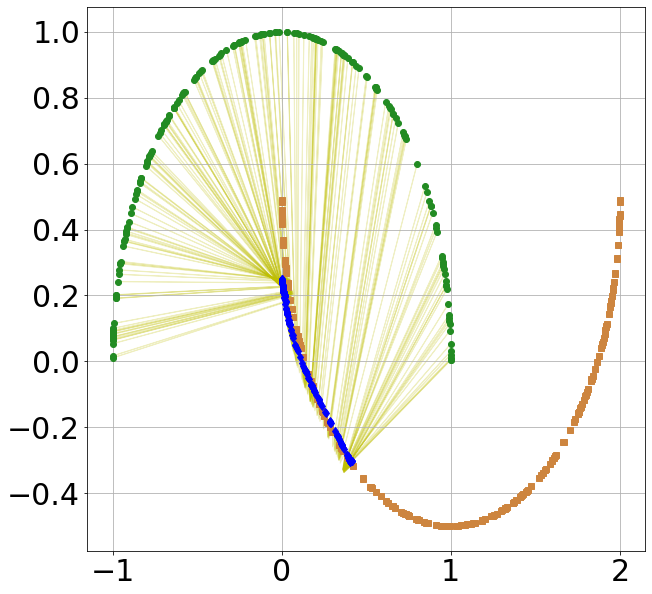

In [27]:
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'o',label='Input (x)', color='forestgreen')
plt.plot(y[:,0],y[:,1],'s',label='Output (y)', color='peru')
plt.plot(Tx[:,0],Tx[:,1],'d',label='Transport (Tx)', color='blue')

for i in range(x.shape[0]):
    plt.arrow(x[i,0], x[i,1], Tx[i,0] - x[i,0], Tx[i,1] - x[i,1],  alpha=0.2, head_width=0.03, head_length = 0.05, fc='y', ec = 'y', color='y')

# plt.legend()
plt.grid()

plt.savefig('./output/Toy/WGAN_GP_Moon.pdf', bbox_inches='tight')


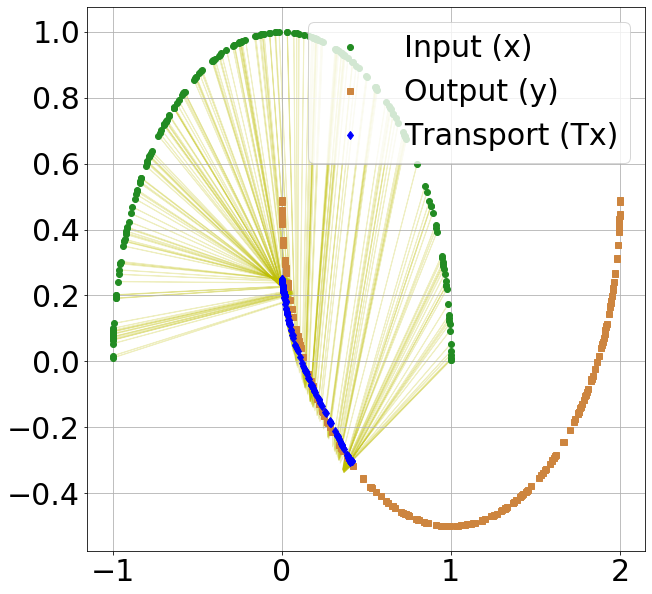

In [28]:
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'o',label='Input (x)', color='forestgreen')
plt.plot(y[:,0],y[:,1],'s',label='Output (y)', color='peru')
plt.plot(Tx[:,0],Tx[:,1],'d',label='Transport (Tx)', color='blue')

for i in range(x.shape[0]):
    plt.arrow(x[i,0], x[i,1], Tx[i,0] - x[i,0], Tx[i,1] - x[i,1],  alpha=0.2, head_width=0.03, head_length = 0.05, fc='y', ec = 'y', color='y')

plt.legend()
plt.grid()

plt.savefig('./output/Toy/WGAN_GP_Moon.jpg', bbox_inches='tight')
